# V471TAU

## Differential Rotation 

The parameters that will be used in each epoch are:

|           Parameter   | 2004       |  2005     |
|              :---:    | :---:      | :---:     |
|$K$ (km/s)             | $149.4$    | $149.4$   |  
|$v_\mathrm{rad}$ (km/s)| $34.7$     | $35.0$    |
|$\phi$                 | $-0.0029$  | $-0.0041$ | 
| $i$                   | $80$       | $80$      |
|$v\sin(i)$ (km/s)      | $90.1$     |  $90.1$   |
| EQW                   | $5.12$     | $5.12$    |

Also, we keep $\chi^2_{\mathrm{aim}} = 0.32 $ as used since the beginning. 

### DATA IN 2004  

### DATA IN 2005  

In [31]:
# load modules
import numpy as N
import matplotlib.pyplot as P
from scipy.optimize import leastsq
import cmocean as cm
import matplotlib.font_manager

# Read file with informations in each run
beta, gamma, chisq, s, sp_ph, test, cool, hot = N.genfromtxt('data/search1_dr_2005.txt', unpack=True)

# Set global min of spot coverage
vmin = sp_ph.min()

#select data within the conditions:
ic = N.bitwise_and(chisq <= 0.3205, test <= 0.003)
beta = beta[ic]; gamma = gamma[ic]; chisq = chisq[ic]; s = s[ic]; sp_ph = sp_ph[ic] 
test = test[ic]; cool = cool[ic]; hot = hot[ic]
#we also add another condition for the data (optional):
isp = N.bitwise_and(sp_ph >= 1.00*vmin, sp_ph <= 1.20*vmin)
beta = beta[isp]; gamma = gamma[isp]; chisq = chisq[isp]; s = s[isp]; sp_ph = sp_ph[isp] 
test = test[isp]; cool = cool[isp]; hot = hot[isp]

# Create a mesh and create new matrix with mesh's shape
x, y = N.meshgrid(N.unique(beta), N.unique(gamma))
m_z = N.ones_like(x)*9999.

for i in range(sp_ph.shape[0]):
    indx = N.bitwise_and(x == beta[i], y == gamma[i])
    m_z[indx] = sp_ph[i]
    
mask = m_z > 1.08*vmin
z=N.ma.array(m_z, mask=mask)  
# find center in the 2d-plane
optimize_func = lambda x: x[0]*beta**2 + x[1]*beta + x[2]*gamma**2 + x[3]*gamma \
                            + x[4]*beta*gamma + x[5] - sp_ph
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)
print('Positions of the center in this plane:')
print('beta = %6.4f and gamma = %6.4f' %(best_x, best_y))

Positions of the center in this plane:
beta = -0.0032 and gamma = 0.0058


/Users/bzaire/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


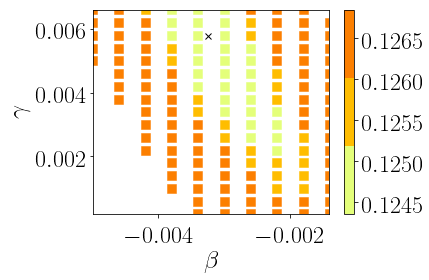

In [32]:
cmap = plt.get_cmap('Wistia', 3)

P.scatter(x,y,c=z, marker = 's', s=80, cmap=cmap, vmin = vmin, vmax = 1.02*vmin)
P.xlim((x.min(), x.max()))
P.ylim((y.min(), y.max()))
P.plot(best_x, best_y, 'x', color='k')
P.colorbar()
P.xlabel(r'$\beta$')
P.ylabel(r'$\gamma$')
P.tight_layout()
